# CIViC Evidence Analysis
This notebook contains an analysis on CIViC evidence data

# Analysis of Normalized Queries

In [3]:
from pathlib import Path
from enum import Enum
import zipfile

import pandas as pd
from civicpy import civic as civicpy
import plotly.express as px

In [4]:
# Use latest cache that has been pushed to the repo
latest_cache_zip_path = sorted(Path().glob("cache-*.pkl.zip"))[-1]
print(f"Using {latest_cache_zip_path} for civicpy cache")

with zipfile.ZipFile(latest_cache_zip_path, "r") as zip_ref:
    zip_ref.extractall()

civicpy.load_cache(local_cache_path=Path("cache.pkl"), on_stale="ignore")

IndexError: list index out of range

## Total Variants in CIViC

In [5]:
civic_variant_ids = civicpy.get_all_variants()
total_number_variants = len(civic_variant_ids)
f"Total Number of variants in CIViC: {total_number_variants}"

'Total Number of variants in CIViC: 3578'

## Total Evidence items in CIViC

Need to remove all rejected evidence items

In [6]:
civic_evidence_ids = civicpy.get_all_evidence(include_status=["accepted", "submitted"])

In [7]:
total_ac_sub_evidence = len(civic_evidence_ids)
f"Total Number of accepted and submitted evidence items in CIViC: {total_ac_sub_evidence}"

'Total Number of accepted and submitted evidence items in CIViC: 9898'

## Total Molecular Profiles in CIViC

In [8]:
civic_molprof_ids = civicpy.get_all_molecular_profiles(include_status=["accepted", "submitted", "rejected"])

# Create analysis functions / global variables 

In [9]:
class VariantNormType(str, Enum):
    """Variation Normalization types"""

    NORMALIZED = "Normalized"
    UNABLE_TO_NORMALIZE = "Unable to Normalize"
    NOT_SUPPORTED = "Not Supported"


VARIANT_NORM_TYPE_VALUES = [v.value for v in VariantNormType.__members__.values()]

In [10]:
class VariantCategory(str, Enum):
    """Create enum for the kind of variants that are in CIViC."""

    EXPRESSION = "Expression"
    EPIGENETIC_MODIFICATION = "Epigenetic Modification"
    FUSION = "Fusion"
    PROTEIN_CONS = "Protein Consequence"
    GENE_FUNC = "Gene Function"
    REARRANGEMENTS = "Rearrangements"
    COPY_NUMBER = "Copy Number"
    OTHER = "Other"
    GENOTYPES_EASY = "Genotypes Easy"
    GENOTYPES_COMPOUND = "Genotypes Compound"
    REGION_DEFINED_VAR = "Region Defined Variant"
    TRANSCRIPT_VAR = "Transcript Variant"  # no attempt to normalize these ones, since there is no query we could use


VARIANT_CATEGORY_VALUES = [v.value for v in VariantCategory.__members__.values()]

## Summary dicts 

These dictionaries will be mutated and used at the end of the analysis

In [11]:
variant_analysis_summary = {
    "Variant Category": VARIANT_NORM_TYPE_VALUES,
    "Count of CIViC Variant Items per Category":[],
    "Fraction of all CIViC Variant Items": [],
    "Percentage of all CIViC Variant Items": [],
    "Fraction of Accepted Variant Items": [],
    "Percentage of Accepted Variant Items": [],
    "Fraction of Not Accepted Variant Items": [],
    "Percentage of Not Accepted Variant Items": []
}
variant_analysis_summary

{'Variant Category': ['Normalized', 'Unable to Normalize', 'Not Supported'],
 'Count of CIViC Variant Items per Category': [],
 'Fraction of all CIViC Variant Items': [],
 'Percentage of all CIViC Variant Items': [],
 'Fraction of Accepted Variant Items': [],
 'Percentage of Accepted Variant Items': [],
 'Fraction of Not Accepted Variant Items': [],
 'Percentage of Not Accepted Variant Items': []}

In [12]:
evidence_analysis_summary = {
    "Variant Category": VARIANT_NORM_TYPE_VALUES,
    "Count of CIViC Evidence Items per Category":[],
    "Fraction of all CIViC Evidence Items": [],
    "Percentage of all CIViC Evidence Items": [],
    "Fraction of Accepted Evidence Items": [],
    "Percentage of Accepted Evidence Items": [],
    "Fraction of Submitted Evidence Items": [],
    "Percentage of Submitted Evidence Items": []
}
evidence_analysis_summary

{'Variant Category': ['Normalized', 'Unable to Normalize', 'Not Supported'],
 'Count of CIViC Evidence Items per Category': [],
 'Fraction of all CIViC Evidence Items': [],
 'Percentage of all CIViC Evidence Items': [],
 'Fraction of Accepted Evidence Items': [],
 'Percentage of Accepted Evidence Items': [],
 'Fraction of Submitted Evidence Items': [],
 'Percentage of Submitted Evidence Items': []}

## Define Analysis Functions

In [13]:
def variant_analysis(df: pd.DataFrame, variant_norm_type: VariantNormType) -> pd.DataFrame:
    """Do variant analysis (counts, percentages)

    :param df: Dataframe of variants
    :param variant_norm_type: The kind of variants that are in `df`
    :return: Transformed dataframe with variant ID duplicates dropped
    """
    # Drop duplicate rows
    df = df.drop_duplicates(subset=["variant_id"])
    variant_ids = list(df["variant_id"])

    # Count
    num_variants = len(variant_ids)
    fraction_variants = f"{num_variants} / {total_number_variants}"
    print(f"\nNumber of {variant_norm_type.value} Variants in CIViC: {fraction_variants}")

    # Percentage
    percentage_variants = f"{num_variants / total_number_variants * 100:.2f}%"
    print(f"Percentage of {variant_norm_type.value} Variants in CIViC: {percentage_variants}")

    # Get accepted counts
    num_accepted_variants = df.variant_accepted.sum()
    fraction_accepted_variants = f"{num_accepted_variants} / {num_variants}"
    print(f"\nNumber of accepted {variant_norm_type.value} Variants: {fraction_accepted_variants}")

    # Get accepted percentage
    percentage_accepted_variants = f"{num_accepted_variants / num_variants * 100:.2f}%"
    print(f"Percentage of accepted {variant_norm_type.value} Variants: {percentage_accepted_variants}")

    # Get not accepted counts
    num_not_accepted_variants = len(df) - num_accepted_variants
    fraction_not_accepted_variants = f"{num_not_accepted_variants} / {num_variants}"
    print(f"\nNumber of not accepted {variant_norm_type.value} Variants: {fraction_not_accepted_variants}")

    # Get not accepted percentage
    percentage_not_accepted_variants = f"{num_not_accepted_variants / num_variants * 100:.2f}%"
    print(f"Percentage of not accepted {variant_norm_type.value} Variants: {percentage_not_accepted_variants}")

    variant_analysis_summary["Count of CIViC Variant Items per Category"].append(num_variants)
    variant_analysis_summary["Fraction of all CIViC Variant Items"].append(fraction_variants)
    variant_analysis_summary["Percentage of all CIViC Variant Items"].append(percentage_variants)
    variant_analysis_summary["Fraction of Accepted Variant Items"].append(fraction_accepted_variants)
    variant_analysis_summary["Percentage of Accepted Variant Items"].append(percentage_accepted_variants)
    variant_analysis_summary["Fraction of Not Accepted Variant Items"].append(fraction_not_accepted_variants)
    variant_analysis_summary["Percentage of Not Accepted Variant Items"].append(percentage_not_accepted_variants)

    return df

In [14]:
def transform_df_evidence_ids(df: pd.DataFrame) -> pd.DataFrame:
    """Transform dataframe to include evidence ID information

    :param df: Dataframe of variants
    :return: Transformed dataframe with evidence ID information
    """
    tmp_df = df.copy(deep=True)

    _variants_evidence_ids = []
    variant_ids = list(tmp_df["variant_id"])

    for v_id in variant_ids:
        _variant_evidence_ids = []

        for variant in civic_variant_ids:
            if int(v_id) == variant.id:
                for mp in variant.molecular_profiles:
                    for e in mp.evidence_items:
                        if e.id not in _variant_evidence_ids:
                            _variant_evidence_ids.append(e.id)

        _variants_evidence_ids.append(_variant_evidence_ids or "")

    tmp_df["evidence_ids"] = _variants_evidence_ids

    # Explode and rename evidence ids field
    tmp_df = tmp_df.explode(column="evidence_ids")
    tmp_df = tmp_df.rename(columns={"evidence_ids": "evidence_id"})

    return tmp_df

In [15]:
def transform_df_evidence(df: pd.DataFrame) -> pd.DataFrame:
    """Transform dataframe to include evidence status, rating, and level

    :param df: Dataframe of variants
    :return: Transformed dataframe with evidence status, rating, and level information.
        Rejected evidence items will be dropped.
    """
    variants_evidence_ids = list(df["evidence_id"])

    # Add evidence status, rating, and level information
    _variants_evidence_statuses = []
    _variants_evidence_ratings = []
    _variants_evidence_levels = []

    for eid in variants_evidence_ids:
        _variant_evidence_statuses = []
        _variant_evidence_ratings = []
        _variant_evidence_levels = []

        for evidence in civic_evidence_ids:
            if eid and (int(eid) == evidence.id):
                if evidence.status not in _variant_evidence_statuses:
                    _variant_evidence_statuses.append(evidence.status)

                if evidence.rating not in _variant_evidence_ratings:
                    _variant_evidence_ratings.append(evidence.rating)

                if evidence.evidence_level not in _variant_evidence_levels:
                    _variant_evidence_levels.append(evidence.evidence_level)
                    
        _variants_evidence_statuses.append(_variant_evidence_statuses or "")
        _variants_evidence_ratings.append(_variant_evidence_ratings or "")
        _variants_evidence_levels.append(_variant_evidence_levels or "")

    df["evidence_status"] = _variants_evidence_statuses
    df["evidence_status"] = df["evidence_status"].str.join(", ")
    df["evidence_rating"] = _variants_evidence_ratings
    df["evidence_level"] = _variants_evidence_levels

    # Drop rejected evidence items
    df = df.drop(df[df.evidence_status == "rejected"].index)

    return df


In [16]:
def evidence_analysis(df: pd.DataFrame, variant_norm_type: VariantNormType) -> pd.DataFrame:
    """Do evidence analysis (counts, percentages)

    :param df: Dataframe of variants
    :param variant_norm_type: The kind of variants that are in `df`
    :return: Transformed dataframe with evidence ID duplicates dropped
    """
    # Count
    num_variant_unique_evidence_items = len(set(df.evidence_id))
    fraction_evidence_items = f"{num_variant_unique_evidence_items} / {total_ac_sub_evidence}"
    print(f"Number of {variant_norm_type.value} Variant Evidence items in CIViC: {fraction_evidence_items}")

    # Percentage
    percentage_evidence_items = f"{num_variant_unique_evidence_items / total_ac_sub_evidence * 100:.2f}%"
    print(f"Percentage of {variant_norm_type.value} Variant Evidence items in CIViC: {percentage_evidence_items}")

    # Add evidence accepted column
    df["evidence_accepted"] = df.evidence_status.map({"accepted": True, "submitted": False})

    # Drop evidence id duplicates
    df = df.drop_duplicates(subset=["evidence_id"])

    # Get accepted counts
    num_accepted_evidences_variants = df.evidence_accepted.sum()
    fraction_accepted_evidences_variants = f"{num_accepted_evidences_variants} / {num_variant_unique_evidence_items}"
    print(f"\nNumber of accepted {variant_norm_type.value} Variant Evidence items: {fraction_accepted_evidences_variants}")

    # Get accepted percentage
    percentage_accepted_evidences_variants = f"{num_accepted_evidences_variants / num_variant_unique_evidence_items * 100:.2f}%"
    print(f"Percentage of accepted {variant_norm_type.value} Variant Evidence items: {percentage_accepted_evidences_variants}")

    # Get submitted counts
    number_submitted_evidences_variants = len(df) - num_accepted_evidences_variants
    fraction_submitted_evidences_variants = f"{number_submitted_evidences_variants} / {num_variant_unique_evidence_items}"
    print(f"\nNumber of submitted {variant_norm_type.value} Variant Evidence items: {fraction_submitted_evidences_variants}")

    # Get submitted percentage
    percentage_submitted_evidences_variants = f"{number_submitted_evidences_variants / num_variant_unique_evidence_items * 100:.2f}%"
    print(f"Percentage of not submitted {variant_norm_type.value} Variant Evidence items: {percentage_submitted_evidences_variants}")

    evidence_analysis_summary["Count of CIViC Evidence Items per Category"].append(num_variant_unique_evidence_items)
    evidence_analysis_summary["Fraction of all CIViC Evidence Items"].append(fraction_evidence_items)
    evidence_analysis_summary["Percentage of all CIViC Evidence Items"].append(percentage_evidence_items)
    evidence_analysis_summary["Fraction of Accepted Evidence Items"].append(fraction_accepted_evidences_variants)
    evidence_analysis_summary["Percentage of Accepted Evidence Items"].append(percentage_accepted_evidences_variants)
    evidence_analysis_summary["Fraction of Submitted Evidence Items"].append(fraction_submitted_evidences_variants)
    evidence_analysis_summary["Percentage of Submitted Evidence Items"].append(percentage_submitted_evidences_variants)

    return df

In [17]:
def transform_df_mp_id(df: pd.DataFrame) -> pd.DataFrame:
    """Transform dataframe to include molecular profile ID information

    :param df: Dataframe of variants
    :return: Transformed dataframe with molecular profile ID information
    """
    tmp_df = df.copy(deep=True)

    variants_molprof_ids = []
    variant_ids = list(tmp_df["variant_id"])

    for v_id in variant_ids:
        variant_molprof_ids = []

        for variant in civic_variant_ids:
            if int(v_id) == variant.id:
                for mp in variant.molecular_profiles:
                    if mp.id not in variant_molprof_ids:
                        variant_molprof_ids.append(mp.id)

        variants_molprof_ids.append(variant_molprof_ids or "")

    tmp_df["molecular_profile_id"] = variants_molprof_ids
    return tmp_df

In [18]:
def transform_df_mp_score(df: pd.DataFrame) -> pd.DataFrame:
    """Transform dataframe to include molecular profile score information

    :param df: Dataframe of variants
    :return: Transformed dataframe with molecular profile score information
    """
    variants_molprof_scores = []
    normalized_variant_molprof_ids = list(df["molecular_profile_id"])

    for mp_ids in normalized_variant_molprof_ids:
        variant_molprof_scores = []
        for mp_id in mp_ids:
            for molprof in civic_molprof_ids:
                if int(mp_id) == molprof.id:
                    if molprof.molecular_profile_score not in variant_molprof_scores:
                        variant_molprof_scores.append(molprof.molecular_profile_score)

        variants_molprof_scores.append(variant_molprof_scores or "")

    df["molecular_profile_score"] = variants_molprof_scores
    return df

In [19]:
def transform_df_mp_score_sum(df: pd.DataFrame) -> pd.DataFrame:
    """Transform dataframe to include molecular profile score sum information

    :param df: Dataframe of variants
    :return: Transformed dataframe with molecular profile score sum information
    """
    df["molecular_profile_score_sum"] = df["molecular_profile_score"].apply(lambda x: sum(x))
    return df

## List of Normalized Variants ID's

In [20]:
normalized_queries_df = pd.read_csv("able_to_normalize_queries.csv", sep="\t")
normalized_queries_df.head()

,variant_id,query,query_type,variant_accepted,vrs_id
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH
3,1986,NC_000003.11:g.10191648G>T,genomic,True,ga4gh:VA.AmLtooLEvgdnEHD5YVWk6u1e2XBe7FiP
4,1987,NC_000003.11:g.10191649A>G,genomic,True,ga4gh:VA.KIz00usFWEmJHNyqmVL61obfgfRPgOIa


## Variant analysis

In [21]:
normalized_queries_df = variant_analysis(normalized_queries_df, VariantNormType.NORMALIZED)
normalized_queries_df.head()


Number of Normalized Variants in CIViC: 1869 / 3578
Percentage of Normalized Variants in CIViC: 52.24%

Number of accepted Normalized Variants: 866 / 1869
Percentage of accepted Normalized Variants: 46.33%

Number of not accepted Normalized Variants: 1003 / 1869
Percentage of not accepted Normalized Variants: 53.67%


,variant_id,query,query_type,variant_accepted,vrs_id
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH
3,1986,NC_000003.11:g.10191648G>T,genomic,True,ga4gh:VA.AmLtooLEvgdnEHD5YVWk6u1e2XBe7FiP
4,1987,NC_000003.11:g.10191649A>G,genomic,True,ga4gh:VA.KIz00usFWEmJHNyqmVL61obfgfRPgOIa


In [22]:
variant_analysis_summary

{'Variant Category': ['Normalized', 'Unable to Normalize', 'Not Supported'],
 'Count of CIViC Variant Items per Category': [1869],
 'Fraction of all CIViC Variant Items': ['1869 / 3578'],
 'Percentage of all CIViC Variant Items': ['52.24%'],
 'Fraction of Accepted Variant Items': ['866 / 1869'],
 'Percentage of Accepted Variant Items': ['46.33%'],
 'Fraction of Not Accepted Variant Items': ['1003 / 1869'],
 'Percentage of Not Accepted Variant Items': ['53.67%']}

## Transform df for evidence analysis

In [23]:
normalized_queries_add_evidence_df = transform_df_evidence_ids(normalized_queries_df)
normalized_queries_add_evidence_df.head()

,variant_id,query,query_type,variant_accepted,vrs_id,evidence_id
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,9347
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,6724
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf,5336
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,10779
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,6723


In [24]:
normalized_queries_add_evidence_df = transform_df_evidence(normalized_queries_add_evidence_df)
normalized_queries_add_evidence_df.head()

,variant_id,query,query_type,variant_accepted,vrs_id,evidence_id,evidence_status,evidence_rating,evidence_level
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,9347,submitted,[3],[C]
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,6724,accepted,[2],[C]
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf,5336,accepted,[2],[C]
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,10779,submitted,[3],[C]
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,6723,accepted,[2],[C]


## Evidence analysis

In [25]:
normalized_queries_add_evidence_df = evidence_analysis(normalized_queries_add_evidence_df, VariantNormType.NORMALIZED)
normalized_queries_add_evidence_df.head()

Number of Normalized Variant Evidence items in CIViC: 5957 / 9898
Percentage of Normalized Variant Evidence items in CIViC: 60.18%

Number of accepted Normalized Variant Evidence items: 2033 / 5957
Percentage of accepted Normalized Variant Evidence items: 34.13%

Number of submitted Normalized Variant Evidence items: 3924 / 5957
Percentage of not submitted Normalized Variant Evidence items: 65.87%


,variant_id,query,query_type,variant_accepted,vrs_id,evidence_id,evidence_status,evidence_rating,evidence_level,evidence_accepted
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,9347,submitted,[3],[C],False
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,6724,accepted,[2],[C],True
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf,5336,accepted,[2],[C],True
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,10779,submitted,[3],[C],False
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,6723,accepted,[2],[C],True


## Impact
molecular profile score

### Import molecular profile id

In [26]:
normalized_queries_add_molprof_df = transform_df_mp_id(normalized_queries_df)
normalized_queries_add_molprof_df.head()

,variant_id,query,query_type,variant_accepted,vrs_id,molecular_profile_id
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,[2362]
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf,[1864]
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,[2361]
3,1986,NC_000003.11:g.10191648G>T,genomic,True,ga4gh:VA.AmLtooLEvgdnEHD5YVWk6u1e2XBe7FiP,[1862]
4,1987,NC_000003.11:g.10191649A>G,genomic,True,ga4gh:VA.KIz00usFWEmJHNyqmVL61obfgfRPgOIa,[1863]


In [27]:
normalized_queries_add_molprof_df.loc[normalized_queries_add_molprof_df["variant_id"] == 190]

,variant_id,query,query_type,variant_accepted,vrs_id,molecular_profile_id
82,190,EGFR Amplification,protein,True,ga4gh:CX.sEHT64Lm86QaTXzw39uKLkBUbEkp4h_X,"[190, 4175, 4346, 4567]"


### Import molecular profile scores

In [28]:
normalized_queries_add_molprof_df = transform_df_mp_score(normalized_queries_add_molprof_df)
normalized_queries_add_molprof_df.head()

,variant_id,query,query_type,variant_accepted,vrs_id,molecular_profile_id,molecular_profile_score
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,[2362],[5.0]
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf,[1864],[5.0]
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,[2361],[5.0]
3,1986,NC_000003.11:g.10191648G>T,genomic,True,ga4gh:VA.AmLtooLEvgdnEHD5YVWk6u1e2XBe7FiP,[1862],[10.0]
4,1987,NC_000003.11:g.10191649A>G,genomic,True,ga4gh:VA.KIz00usFWEmJHNyqmVL61obfgfRPgOIa,[1863],[5.0]


In [29]:
normalized_queries_add_molprof_df.loc[normalized_queries_add_molprof_df["variant_id"] == 190]

,variant_id,query,query_type,variant_accepted,vrs_id,molecular_profile_id,molecular_profile_score
82,190,EGFR Amplification,protein,True,ga4gh:CX.sEHT64Lm86QaTXzw39uKLkBUbEkp4h_X,"[190, 4175, 4346, 4567]","[173.0, 5.0, 0.0]"


In [30]:
normalized_queries_add_molprof_df = transform_df_mp_score_sum(normalized_queries_add_molprof_df)
normalized_queries_add_molprof_df.head()

,variant_id,query,query_type,variant_accepted,vrs_id,molecular_profile_id,molecular_profile_score,molecular_profile_score_sum
0,2489,NC_000003.11:g.10191648_10191649insC,genomic,True,ga4gh:VA.A34ZoIhq4xBuQbcE3bkj29n6diS6RzLB,[2362],[5.0],5.0
1,1988,NC_000003.11:g.10191649A>T,genomic,True,ga4gh:VA.JcEpDvhUtgDWU4A-bxqLUuczBNb8QqRf,[1864],[5.0],5.0
2,2488,3-10191647-T-G,genomic,True,ga4gh:VA.7nGd8dgHbqtxMHk_rLxrB6_IMAzJ8XnH,[2361],[5.0],5.0
3,1986,NC_000003.11:g.10191648G>T,genomic,True,ga4gh:VA.AmLtooLEvgdnEHD5YVWk6u1e2XBe7FiP,[1862],[10.0],10.0
4,1987,NC_000003.11:g.10191649A>G,genomic,True,ga4gh:VA.KIz00usFWEmJHNyqmVL61obfgfRPgOIa,[1863],[5.0],5.0


In [31]:
normalized_queries_add_molprof_df.loc[normalized_queries_add_molprof_df["variant_id"] == 190]

,variant_id,query,query_type,variant_accepted,vrs_id,molecular_profile_id,molecular_profile_score,molecular_profile_score_sum
82,190,EGFR Amplification,protein,True,ga4gh:CX.sEHT64Lm86QaTXzw39uKLkBUbEkp4h_X,"[190, 4175, 4346, 4567]","[173.0, 5.0, 0.0]",178.0


# Analysis of Unable to Normalize Queries

## List of Unable to Normalize Variant ID's

In [32]:
not_normalized_queries_df = pd.read_csv("unable_to_normalize_queries.csv", sep="\t")
not_normalized_queries_df.head()

,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati..."
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati..."
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati..."
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati..."
4,4004,TERT C250T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati..."


## Variant analysis

In [33]:
not_normalized_queries_df = variant_analysis(not_normalized_queries_df, VariantNormType.UNABLE_TO_NORMALIZE)
not_normalized_queries_df.head()


Number of Unable to Normalize Variants in CIViC: 63 / 3578
Percentage of Unable to Normalize Variants in CIViC: 1.76%

Number of accepted Unable to Normalize Variants: 9 / 63
Percentage of accepted Unable to Normalize Variants: 14.29%

Number of not accepted Unable to Normalize Variants: 54 / 63
Percentage of not accepted Unable to Normalize Variants: 85.71%


,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati..."
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati..."
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati..."
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati..."
4,4004,TERT C250T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati..."


## Transform df for evidence analysis

In [34]:
not_normalized_quer_add_evidence_df = transform_df_evidence_ids(not_normalized_queries_df)
not_normalized_quer_add_evidence_df.head()

,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings,evidence_id
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",1812
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",10128
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",10135
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",655
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",1646


In [35]:
not_normalized_quer_add_evidence_df = transform_df_evidence(not_normalized_quer_add_evidence_df)
not_normalized_quer_add_evidence_df.head()

,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings,evidence_id,evidence_status,evidence_rating,evidence_level
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",1812,accepted,[1],[C]
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",10128,submitted,[3],[D]
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",10135,submitted,[3],[D]
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",655,accepted,[5],[B]
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",1646,accepted,[3],[B]


## Evidence analysis

In [36]:
not_normalized_quer_add_evidence_df = evidence_analysis(not_normalized_quer_add_evidence_df, VariantNormType.UNABLE_TO_NORMALIZE)
not_normalized_quer_add_evidence_df.head()

Number of Unable to Normalize Variant Evidence items in CIViC: 80 / 9898
Percentage of Unable to Normalize Variant Evidence items in CIViC: 0.81%

Number of accepted Unable to Normalize Variant Evidence items: 14 / 80
Percentage of accepted Unable to Normalize Variant Evidence items: 17.50%

Number of submitted Unable to Normalize Variant Evidence items: 66 / 80
Percentage of not submitted Unable to Normalize Variant Evidence items: 82.50%


,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings,evidence_id,evidence_status,evidence_rating,evidence_level,evidence_accepted
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",1812,accepted,[1],[C],True
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",10128,submitted,[3],[D],False
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",10135,submitted,[3],[D],False
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",655,accepted,[5],[B],True
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",1646,accepted,[3],[B],True


## Impact
molecular profile score

### Import molecular profile id

In [37]:
not_normalized_queries_add_molprof_df = transform_df_mp_id(not_normalized_queries_df)
not_normalized_queries_add_molprof_df.head()

,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings,molecular_profile_id
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",[729]
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3586]
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3593]
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",[244]
4,4004,TERT C250T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3872]


### Import molecular profile scores

In [38]:
not_normalized_queries_add_molprof_df = transform_df_mp_score(not_normalized_queries_add_molprof_df)
not_normalized_queries_add_molprof_df.head()

,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings,molecular_profile_id,molecular_profile_score
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",[729],[2.5]
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3586],[0.0]
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3593],[0.0]
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",[244],[40.0]
4,4004,TERT C250T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3872],[0.0]


In [39]:
not_normalized_queries_add_molprof_df = transform_df_mp_score_sum(not_normalized_queries_add_molprof_df)
not_normalized_queries_add_molprof_df.head()

,variant_id,query,query_type,variant_accepted,exception_raised,message,warnings,molecular_profile_id,molecular_profile_score,molecular_profile_score_sum
0,748,MLH1 *757L,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",[729],[2.5],2.5
1,3718,AR A748V,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3586],[0.0],0.0
2,3725,AR A765T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3593],[0.0],0.0
3,248,TERT C228T,protein,True,False,unable to normalize,"[""Unable to find valid result for classificati...",[244],[40.0],40.0
4,4004,TERT C250T,protein,False,False,unable to normalize,"[""Unable to find valid result for classificati...",[3872],[0.0],0.0


# Analysis of Not Supported Variants

### List of Not Supported Variant ID's

In [40]:
not_supported_queries_df = pd.read_csv("not_supported_variants.csv", sep="\t")
not_supported_queries_df.head()

,variant_id,gene_name,variant_name,category,variant_accepted
0,4170,VHL,NaN,Transcript Variant,False
1,4417,ALK,FBXO11::ALK,Fusion,False
2,4214,VHL,NaN,Transcript Variant,False
3,4216,VHL,NaN,Transcript Variant,False
4,4278,VHL,NaN,Transcript Variant,False


## Variant Analysis

In [41]:
not_supported_queries_df = variant_analysis(not_supported_queries_df, VariantNormType.NOT_SUPPORTED)
not_supported_queries_df.head()


Number of Not Supported Variants in CIViC: 1622 / 3578
Percentage of Not Supported Variants in CIViC: 45.33%

Number of accepted Not Supported Variants: 788 / 1622
Percentage of accepted Not Supported Variants: 48.58%

Number of not accepted Not Supported Variants: 834 / 1622
Percentage of not accepted Not Supported Variants: 51.42%


,variant_id,gene_name,variant_name,category,variant_accepted
0,4170,VHL,NaN,Transcript Variant,False
1,4417,ALK,FBXO11::ALK,Fusion,False
2,4214,VHL,NaN,Transcript Variant,False
3,4216,VHL,NaN,Transcript Variant,False
4,4278,VHL,NaN,Transcript Variant,False


### Not Supported Variant Analysis by Subcategory 

In [42]:
not_supported_variant_analysis_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Count of CIViC Variant Items per Category":[],
    "Fraction of Not Supported Variant Items": [],
    "Percent of Not Supported Variant Items": [],
    "Fraction of all CIViC Variant Items": [],
    "Percent of all CIViC Variant Items": [],
    "Fraction of Accepted Variant Items": [],
    "Percent of Accepted Variant Items": [],
    "Fraction of Not Accepted Variant Items": [],
    "Percent of Not Accepted Variant Items": []
}

In [43]:
not_supported_variant_categories_summary_data = dict()
total_number_unique_not_supported_variants = len(set(not_supported_queries_df.variant_id))

for category in VARIANT_CATEGORY_VALUES:  # These are not supported categories
    not_supported_variant_categories_summary_data[category] = {}
    category_df = not_supported_queries_df[not_supported_queries_df.category == category]

    # Count
    number_unique_not_supported_category_variants = len(set(category_df.variant_id))
    not_supported_variant_categories_summary_data[category]["number_unique_not_supported_category_variants"] = number_unique_not_supported_category_variants

    # Fraction
    fraction_not_supported_category_variant_of_civic = f"{number_unique_not_supported_category_variants} / {total_number_variants}"
    not_supported_variant_categories_summary_data[category]["fraction_not_supported_category_variant_of_civic"] = fraction_not_supported_category_variant_of_civic

    # Percent
    percent_not_supported_category_variant_of_civic = f"{number_unique_not_supported_category_variants / total_number_variants * 100:.2f}%"
    not_supported_variant_categories_summary_data[category]["percent_not_supported_category_variant_of_civic"] = percent_not_supported_category_variant_of_civic

    # Not supported fraction
    fraction_not_supported_category_variant_of_total_not_supported = f"{number_unique_not_supported_category_variants} / {total_number_unique_not_supported_variants}"
    not_supported_variant_categories_summary_data[category]["fraction_not_supported_category_variant_of_total_not_supported"] = fraction_not_supported_category_variant_of_total_not_supported

    # Not supported percent
    percent_not_supported_category_variant_of_total_not_supported = f"{number_unique_not_supported_category_variants / total_number_unique_not_supported_variants * 100:.2f}%"
    not_supported_variant_categories_summary_data[category]["percent_not_supported_category_variant_of_total_not_supported"] = percent_not_supported_category_variant_of_total_not_supported

    # Accepted fraction
    number_accepted_not_supported_category_variants = category_df.variant_accepted.sum()
    fraction_accepted_not_supported_category_variants = f"{number_accepted_not_supported_category_variants} / {number_unique_not_supported_category_variants}"
    not_supported_variant_categories_summary_data[category]["fraction_accepted_not_supported_category_variants"] = fraction_accepted_not_supported_category_variants

    # Accepted percent
    percentage_accepted_not_supported_category_variants = f"{number_accepted_not_supported_category_variants / number_unique_not_supported_category_variants * 100:.2f}%"
    not_supported_variant_categories_summary_data[category]["percentage_accepted_not_supported_category_variants"] = percentage_accepted_not_supported_category_variants

    # Not accepted fraction
    number_not_accepted_not_supported_category_variants = len(category_df) - number_accepted_not_supported_category_variants
    fraction_not_accepted_not_supported_category_variants = f" {number_not_accepted_not_supported_category_variants} / {number_unique_not_supported_category_variants}"
    not_supported_variant_categories_summary_data[category]["fraction_not_accepted_not_supported_category_variants"] = fraction_not_accepted_not_supported_category_variants

    # Not accepted percent
    percentage_not_accepted_not_supported_category_variants = f"{number_not_accepted_not_supported_category_variants / number_unique_not_supported_category_variants * 100:.2f}%"
    not_supported_variant_categories_summary_data[category]["percentage_not_accepted_not_supported_category_variants"] = percentage_not_accepted_not_supported_category_variants

    not_supported_variant_analysis_summary["Count of CIViC Variant Items per Category"].append(number_unique_not_supported_category_variants)
    not_supported_variant_analysis_summary["Fraction of all CIViC Variant Items"].append(fraction_not_supported_category_variant_of_civic)
    not_supported_variant_analysis_summary["Percent of all CIViC Variant Items"].append(percent_not_supported_category_variant_of_civic)
    not_supported_variant_analysis_summary["Fraction of Not Supported Variant Items"].append(fraction_not_supported_category_variant_of_total_not_supported)
    not_supported_variant_analysis_summary["Percent of Not Supported Variant Items"].append(percent_not_supported_category_variant_of_total_not_supported)
    not_supported_variant_analysis_summary["Fraction of Accepted Variant Items"].append(fraction_accepted_not_supported_category_variants)
    not_supported_variant_analysis_summary["Percent of Accepted Variant Items"].append(percentage_accepted_not_supported_category_variants)
    not_supported_variant_analysis_summary["Fraction of Not Accepted Variant Items"].append(fraction_not_accepted_not_supported_category_variants)
    not_supported_variant_analysis_summary["Percent of Not Accepted Variant Items"].append(percentage_not_accepted_not_supported_category_variants)

## Transform df for evidence analysis

In [44]:
not_supported_variants_add_evidence_df = transform_df_evidence_ids(not_supported_queries_df)
not_supported_variants_add_evidence_df.head()

,variant_id,gene_name,variant_name,category,variant_accepted,evidence_id
0,4170,VHL,NaN,Transcript Variant,False,10647
1,4417,ALK,FBXO11::ALK,Fusion,False,7428
2,4214,VHL,NaN,Transcript Variant,False,10752
3,4216,VHL,NaN,Transcript Variant,False,10754
4,4278,VHL,NaN,Transcript Variant,False,10958


In [45]:
not_supported_variants_add_evidence_df.loc[not_supported_variants_add_evidence_df['evidence_id'] == '']

,variant_id,gene_name,variant_name,category,variant_accepted,evidence_id
62,1027,ABL1,BCR::ABL D276G,Fusion,True,
118,4508,ABL1,BCR::ABL T315I,Fusion,False,
126,1025,ABL1,BCR::ABL Y253H,Fusion,True,
268,4270,EGFR,EGFR ITD,Rearrangements,False,
285,4020,EML4,EML4::NTRK3,Fusion,False,
715,3225,NTRK1,LMNA::NTRK1 e11-e10,Fusion,True,
716,3223,NTRK1,LMNA::NTRK1 e2-e10,Fusion,True,
717,3224,NTRK1,LMNA::NTRK1 e2-e11,Fusion,True,


In [46]:
not_supported_variants_add_evidence_df = transform_df_evidence(not_supported_variants_add_evidence_df)
not_supported_variants_add_evidence_df.head()

,variant_id,gene_name,variant_name,category,variant_accepted,evidence_id,evidence_status,evidence_rating,evidence_level
0,4170,VHL,NaN,Transcript Variant,False,10647,submitted,[2],[C]
1,4417,ALK,FBXO11::ALK,Fusion,False,7428,submitted,[3],[C]
2,4214,VHL,NaN,Transcript Variant,False,10752,submitted,[3],[C]
3,4216,VHL,NaN,Transcript Variant,False,10754,submitted,[3],[C]
4,4278,VHL,NaN,Transcript Variant,False,10958,submitted,[3],[C]


## Evidence analysis

In [47]:
not_supported_variants_add_evidence_df = evidence_analysis(not_supported_variants_add_evidence_df, VariantNormType.NOT_SUPPORTED)
not_supported_variants_add_evidence_df.head()

Number of Not Supported Variant Evidence items in CIViC: 4365 / 9898
Percentage of Not Supported Variant Evidence items in CIViC: 44.10%

Number of accepted Not Supported Variant Evidence items: 2215 / 4365
Percentage of accepted Not Supported Variant Evidence items: 50.74%

Number of submitted Not Supported Variant Evidence items: 2150 / 4365
Percentage of not submitted Not Supported Variant Evidence items: 49.26%


,variant_id,gene_name,variant_name,category,variant_accepted,evidence_id,evidence_status,evidence_rating,evidence_level,evidence_accepted
0,4170,VHL,NaN,Transcript Variant,False,10647,submitted,[2],[C],False
1,4417,ALK,FBXO11::ALK,Fusion,False,7428,submitted,[3],[C],False
2,4214,VHL,NaN,Transcript Variant,False,10752,submitted,[3],[C],False
3,4216,VHL,NaN,Transcript Variant,False,10754,submitted,[3],[C],False
4,4278,VHL,NaN,Transcript Variant,False,10958,submitted,[3],[C],False


### Not Supported Variant Evidence Analysis by Subcategory 

 List all the possible variant categories, have to use non unique file since evidence items are used more than once across groups


In [48]:
not_supported_variant_categories = not_supported_variants_add_evidence_df.category.unique()
[v for v in not_supported_variant_categories]

['Transcript Variant',
 'Fusion',
 'Region Defined Variant',
 'Protein Consequence',
 'Other',
 'Rearrangements',
 'Copy Number',
 'Expression',
 'Gene Function',
 'Genotypes Compound',
 'Epigenetic Modification',
 'Genotypes Easy']

Evidence ID's can qualify for more than one kind of variant category

In [49]:
duplicate = not_supported_variants_add_evidence_df[not_supported_variants_add_evidence_df.duplicated("evidence_id", keep=False)]
duplicate

,variant_id,gene_name,variant_name,category,variant_accepted,evidence_id,evidence_status,evidence_rating,evidence_level,evidence_accepted


In [50]:
not_supported_variant_evidence_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Count of CIViC Evidence Items per Category":[],
    "Fraction of CIViC Evidence Items": [],
    "Percent of all CIViC Evidence Items": [],
    "Fraction of Not Supported Variant Evidence Items": [],
    "Percent of Not Supported Variant Evidence Items": [],
    "Fraction of Accepted Evidence Items": [],
    "Percent of Accepted Evidence Items": [],
    "Fraction of Submitted Evidence Items": [],
    "Percent of Submitted Evidence Items": []
}

In [51]:
not_supported_variant_categories_evidence_summary_data = dict()
total_number_not_supported_variant_unique_evidence_items = len(set(not_supported_variants_add_evidence_df.evidence_id))

for category in VARIANT_CATEGORY_VALUES:
    not_supported_variant_categories_evidence_summary_data[category] = {}
    evidence_category_df = not_supported_variants_add_evidence_df[not_supported_variants_add_evidence_df.category == category]
    evidence_category_df = evidence_category_df.drop_duplicates(subset=["evidence_id"])

    # Count
    number_unique_not_supported_category_evidence = len(set(evidence_category_df.evidence_id))
    not_supported_variant_categories_evidence_summary_data[category]["number_unique_not_supported_category_evidence"] = number_unique_not_supported_category_evidence

    # Fraction
    fraction_not_supported_category_variant_evidence_of_civic = f"{number_unique_not_supported_category_evidence} / {total_ac_sub_evidence}"
    not_supported_variant_categories_evidence_summary_data[category]["fraction_not_supported_category_variant_evidence_of_civic"] = fraction_not_supported_category_variant_evidence_of_civic

    # Percent
    percent_not_supported_category_variant_evidence_of_civic = f"{number_unique_not_supported_category_evidence / total_ac_sub_evidence * 100:.2f}%"
    not_supported_variant_categories_evidence_summary_data[category]["percent_not_supported_category_variant_evidence_of_civic"] = percent_not_supported_category_variant_evidence_of_civic

    # Not supported fraction
    fraction_not_supported_category_variant_evidence_of_total_not_supported = f"{number_unique_not_supported_category_evidence} / {total_number_not_supported_variant_unique_evidence_items}"
    not_supported_variant_categories_evidence_summary_data[category]["fraction_not_supported_category_variant_evidence_of_total_not_supported"] = fraction_not_supported_category_variant_evidence_of_total_not_supported

    # Not supported percent
    percent_not_supported_category_variant_evidence_of_total_not_supported = f"{number_unique_not_supported_category_evidence / total_number_not_supported_variant_unique_evidence_items * 100:.2f}%"
    not_supported_variant_categories_evidence_summary_data[category]["percent_not_supported_category_variant_evidence_of_total_not_supported"] = percent_not_supported_category_variant_evidence_of_total_not_supported

    # Accepted fraction
    number_accepted_not_supported_category_variant_evidence = evidence_category_df.evidence_accepted.sum()
    fraction_accepted_evidence_not_supported_category_variants = f"{number_accepted_not_supported_category_variant_evidence} / {number_unique_not_supported_category_evidence}"
    not_supported_variant_categories_evidence_summary_data[category]["fraction_accepted_evidence_not_supported_category_variants"] = fraction_accepted_evidence_not_supported_category_variants

    # Accepted percent
    percentage_accepted_evidence_not_supported_category_variants = f"{number_accepted_not_supported_category_variant_evidence / number_unique_not_supported_category_evidence * 100:.2f}%"
    not_supported_variant_categories_evidence_summary_data[category]["percentage_accepted_evidence_not_supported_category_variants"] = percentage_accepted_evidence_not_supported_category_variants

    # Submitted fraction
    number_submitted_not_supported_category_variant_evidence = number_unique_not_supported_category_evidence - evidence_category_df.evidence_accepted.sum()
    fraction_submitted_evidence_not_supported_category_variants = f"{number_submitted_not_supported_category_variant_evidence} / {number_unique_not_supported_category_evidence}"
    not_supported_variant_categories_evidence_summary_data[category]["fraction_submitted_evidence_not_supported_category_variants"] = fraction_submitted_evidence_not_supported_category_variants

    # Submitted percent
    percentage_submitted_evidence_not_supported_category_variants = f"{number_submitted_not_supported_category_variant_evidence / number_unique_not_supported_category_evidence * 100:.2f}%"
    not_supported_variant_categories_evidence_summary_data[category]["percentage_submitted_evidence_not_supported_category_variants"] = percentage_submitted_evidence_not_supported_category_variants
   
    not_supported_variant_evidence_summary["Count of CIViC Evidence Items per Category"].append(number_unique_not_supported_category_evidence)
    not_supported_variant_evidence_summary["Fraction of CIViC Evidence Items"].append(fraction_not_supported_category_variant_evidence_of_civic)
    not_supported_variant_evidence_summary["Percent of all CIViC Evidence Items"].append(percent_not_supported_category_variant_evidence_of_civic)
    not_supported_variant_evidence_summary["Fraction of Not Supported Variant Evidence Items"].append(fraction_not_supported_category_variant_evidence_of_total_not_supported)
    not_supported_variant_evidence_summary["Percent of Not Supported Variant Evidence Items"].append(percent_not_supported_category_variant_evidence_of_total_not_supported)
    not_supported_variant_evidence_summary["Fraction of Accepted Evidence Items"].append(fraction_accepted_evidence_not_supported_category_variants)
    not_supported_variant_evidence_summary["Percent of Accepted Evidence Items"].append(percentage_accepted_evidence_not_supported_category_variants)
    not_supported_variant_evidence_summary["Fraction of Submitted Evidence Items"].append(fraction_submitted_evidence_not_supported_category_variants)
    not_supported_variant_evidence_summary["Percent of Submitted Evidence Items"].append(percentage_submitted_evidence_not_supported_category_variants)

## Impact
molecular profile score

### Import molecular profile id

In [52]:
not_supported_variants_add_molprof_df = transform_df_mp_id(not_supported_queries_df)
not_supported_variants_add_molprof_df.head()

,variant_id,gene_name,variant_name,category,variant_accepted,molecular_profile_id
0,4170,VHL,NaN,Transcript Variant,False,[4038]
1,4417,ALK,FBXO11::ALK,Fusion,False,[4350]
2,4214,VHL,NaN,Transcript Variant,False,[4082]
3,4216,VHL,NaN,Transcript Variant,False,[4084]
4,4278,VHL,NaN,Transcript Variant,False,[4146]


### Import molecular profile scores

In [53]:
not_supported_variants_add_molprof_df = transform_df_mp_score(not_supported_variants_add_molprof_df)
not_supported_variants_add_molprof_df.head()

,variant_id,gene_name,variant_name,category,variant_accepted,molecular_profile_id,molecular_profile_score
0,4170,VHL,NaN,Transcript Variant,False,[4038],[0.0]
1,4417,ALK,FBXO11::ALK,Fusion,False,[4350],[0.0]
2,4214,VHL,NaN,Transcript Variant,False,[4082],[0.0]
3,4216,VHL,NaN,Transcript Variant,False,[4084],[0.0]
4,4278,VHL,NaN,Transcript Variant,False,[4146],[0.0]


In [54]:
not_supported_variants_add_molprof_df = transform_df_mp_score_sum(not_supported_variants_add_molprof_df)
not_supported_variants_add_molprof_df.head()

,variant_id,gene_name,variant_name,category,variant_accepted,molecular_profile_id,molecular_profile_score,molecular_profile_score_sum
0,4170,VHL,NaN,Transcript Variant,False,[4038],[0.0],0.0
1,4417,ALK,FBXO11::ALK,Fusion,False,[4350],[0.0],0.0
2,4214,VHL,NaN,Transcript Variant,False,[4082],[0.0],0.0
3,4216,VHL,NaN,Transcript Variant,False,[4084],[0.0],0.0
4,4278,VHL,NaN,Transcript Variant,False,[4146],[0.0],0.0


### Impact by Subcategory

In [55]:
not_supported_impact_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "CIVIC Total Sum Impact Score": [],
    'Average Impact Score per Variant': [],
    'Average Impact Score per Evidence Item':[],
    "Total Number Evidence Items": [v["number_unique_not_supported_category_evidence"] for v in not_supported_variant_categories_evidence_summary_data.values()],
    "% Accepted Evidence Items": [v["percentage_accepted_evidence_not_supported_category_variants"] for v in not_supported_variant_categories_evidence_summary_data.values()],
    "Total Number Variants": [v["number_unique_not_supported_category_variants"] for v in not_supported_variant_categories_summary_data.values()]
}

In [56]:
not_supported_variant_categories_impact_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    not_supported_variant_categories_impact_data[category] = {}
    impact_category_df = not_supported_variants_add_molprof_df[not_supported_variants_add_molprof_df.category == category]

    total_sum_not_supported_category_impact = impact_category_df["molecular_profile_score_sum"].sum()
    not_supported_variant_categories_impact_data[category]["total_sum_not_supported_category_impact"] = total_sum_not_supported_category_impact

    avg_impact_score_variant = total_sum_not_supported_category_impact/ number_unique_not_supported_category_variants
    not_supported_variant_categories_impact_data[category]["avg_impact_score_variant"]=  avg_impact_score_variant

    avg_impact_score_evidence = total_sum_not_supported_category_impact/ number_unique_not_supported_category_evidence
    not_supported_variant_categories_impact_data[category]["avg_impact_score_evidence"]=  avg_impact_score_evidence

    not_supported_impact_summary["CIVIC Total Sum Impact Score"].append(total_sum_not_supported_category_impact)
    not_supported_impact_summary["Average Impact Score per Variant"].append(avg_impact_score_variant)
    not_supported_impact_summary["Average Impact Score per Evidence Item"].append(avg_impact_score_evidence)


    print(number_unique_not_supported_category_variants)
    print(f"{category}: {total_sum_not_supported_category_impact}")

385
Expression: 3618.0
385
Epigenetic Modification: 285.5
385
Fusion: 6600.75
385
Protein Consequence: 2683.75
385
Gene Function: 1805.5
385
Rearrangements: 653.0
385
Copy Number: 225.0
385
Other: 673.5
385
Genotypes Easy: 195.0
385
Genotypes Compound: 117.5
385
Region Defined Variant: 8353.5
385
Transcript Variant: 356.5


In [57]:
not_supported_variant_impact_df = pd.DataFrame(not_supported_impact_summary)

In [58]:
not_supported_variant_impact_df

,Category,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants
0,Expression,3618.00,9.397403,7.681529,617,55.43%,291
1,Epigenetic Modification,285.50,0.741558,0.606157,24,91.67%,15
2,Fusion,6600.75,17.144805,14.014331,1241,59.39%,308
3,Protein Consequence,2683.75,6.970779,5.697983,301,63.46%,128
4,Gene Function,1805.50,4.689610,3.833333,348,44.25%,90
5,Rearrangements,653.00,1.696104,1.386412,136,38.97%,52
6,Copy Number,225.00,0.584416,0.477707,64,42.19%,34
7,Other,673.50,1.749351,1.429936,162,37.04%,93
8,Genotypes Easy,195.00,0.506494,0.414013,23,56.52%,11
9,Genotypes Compound,117.50,0.305195,0.249469,7,57.14%,6


In [59]:
not_supported_variant_impact_df.to_csv('../not_supported_variant_impact_df.csv', index=False)

# Summary

## Variant Analysis

In [60]:
all_variant_df = pd.DataFrame(variant_analysis_summary)

In [61]:
all_variant_df["Percentage of all CIViC Variant Items"] = all_variant_df["Fraction of all CIViC Variant Items"].astype(str) + "  (" + all_variant_df["Percentage of all CIViC Variant Items"] + ")"
all_variant_df["Percentage of Accepted Variant Items"] = all_variant_df["Fraction of Accepted Variant Items"].astype(str) + "  (" + all_variant_df["Percentage of Accepted Variant Items"] + ")"
all_variant_df["Percentage of Not Accepted Variant Items"] = all_variant_df["Fraction of Not Accepted Variant Items"].astype(str) + "  (" + all_variant_df["Percentage of Not Accepted Variant Items"] + ")"

In [62]:
all_variant_df = all_variant_df.drop(["Fraction of all CIViC Variant Items", "Fraction of Accepted Variant Items", "Fraction of Not Accepted Variant Items"], axis=1)

In [63]:
all_variant_percent_status_df = all_variant_df.drop(["Percentage of all CIViC Variant Items", "Count of CIViC Variant Items per Category"], axis=1)

for_merge_all_variant_percent_of_civic_df = all_variant_df.drop(["Percentage of Accepted Variant Items", "Percentage of Not Accepted Variant Items"], axis=1)

all_variant_percent_of_civic_df = for_merge_all_variant_percent_of_civic_df.drop(["Count of CIViC Variant Items per Category"], axis=1)

In [64]:
for_merge_all_variant_percent_of_civic_df.to_csv('../for_merge_all_variant_percent_of_civic_df.csv', index=False)


Summary Table 1: The table below shows the 3 categories that CIViC variants were divided into after normalization and what percentage they make up of all variants in CIViC data. 

In [65]:
all_variant_percent_of_civic_df = all_variant_percent_of_civic_df.set_index("Variant Category")
all_variant_percent_of_civic_df

,Percentage of all CIViC Variant Items
Variant Category,
Normalized,1869 / 3578 (52.24%)
Unable to Normalize,63 / 3578 (1.76%)
Not Supported,1622 / 3578 (45.33%)


In [66]:
civic_summary_table_1 = all_variant_percent_of_civic_df

Summary Table 2: The table below shows the 3 categories that CIViC variants were divided into after normalization and what percentage of the variants in each category are accepted (have at least one evidence item that is accepted) or not.

In [67]:
all_variant_percent_status_df = all_variant_percent_status_df.set_index("Variant Category")
all_variant_percent_status_df

,Percentage of Accepted Variant Items,Percentage of Not Accepted Variant Items
Variant Category,,
Normalized,866 / 1869 (46.33%),1003 / 1869 (53.67%)
Unable to Normalize,9 / 63 (14.29%),54 / 63 (85.71%)
Not Supported,788 / 1622 (48.58%),834 / 1622 (51.42%)


In [68]:
civic_summary_table_2 = all_variant_percent_status_df

In [69]:
not_supported_variant_df = pd.DataFrame(not_supported_variant_analysis_summary)

In [70]:
not_supported_variant_df["Percent of Not Supported Variant Items"] = not_supported_variant_df["Fraction of Not Supported Variant Items"].astype(str) + "  (" + not_supported_variant_df["Percent of Not Supported Variant Items"] + ")"
not_supported_variant_df["Percent of all CIViC Variant Items"] = not_supported_variant_df["Fraction of all CIViC Variant Items"].astype(str) + "  (" + not_supported_variant_df["Percent of all CIViC Variant Items"] + ")"
not_supported_variant_df["Percent of Accepted Variant Items"] = not_supported_variant_df["Fraction of Accepted Variant Items"].astype(str) + "  (" + not_supported_variant_df["Percent of Accepted Variant Items"] + ")"
not_supported_variant_df["Percent of Not Accepted Variant Items"] = not_supported_variant_df["Fraction of Not Accepted Variant Items"].astype(str) + "  (" + not_supported_variant_df["Percent of Not Accepted Variant Items"] + ")"

In [71]:
not_supported_variant_df = not_supported_variant_df.drop(["Fraction of Not Supported Variant Items", "Fraction of all CIViC Variant Items", "Fraction of Accepted Variant Items", "Fraction of Not Accepted Variant Items"], axis=1)

In [72]:
for_merge_not_supported_variant_percent_of_civic_df = not_supported_variant_df.drop(["Percent of Not Supported Variant Items", "Percent of Accepted Variant Items", "Percent of Not Accepted Variant Items"], axis=1)

not_supported_variant_percent_of_civic_df = for_merge_not_supported_variant_percent_of_civic_df.drop(["Count of CIViC Variant Items per Category"], axis=1)

not_supported_variant_percent_of_not_supported_df = not_supported_variant_df.drop(["Percent of all CIViC Variant Items", "Count of CIViC Variant Items per Category", "Percent of Accepted Variant Items", "Percent of Not Accepted Variant Items"], axis=1)

not_supported_variant_percent_evidence_df = not_supported_variant_df.drop(["Percent of all CIViC Variant Items", "Percent of Not Supported Variant Items","Count of CIViC Variant Items per Category"], axis=1)

In [73]:
for_merge_not_supported_variant_percent_of_civic_df.to_csv('../for_merge_not_supported_variant_percent_of_civic_df.csv', index=False)

Summary Table 3: The table below shows the categories that the Not Supported variants were broken into and what percentage of all CIViC variants they make up. These percentages will not add up to 100% because Not Supported variants make up 45.62% of all CIViC variants. 

In [74]:
not_supported_variant_percent_of_civic_df = not_supported_variant_percent_of_civic_df.set_index("Category")
not_supported_variant_percent_of_civic_df

,Percent of all CIViC Variant Items
Category,
Expression,291 / 3578 (8.13%)
Epigenetic Modification,15 / 3578 (0.42%)
Fusion,308 / 3578 (8.61%)
Protein Consequence,128 / 3578 (3.58%)
Gene Function,90 / 3578 (2.52%)
Rearrangements,52 / 3578 (1.45%)
Copy Number,34 / 3578 (0.95%)
Other,93 / 3578 (2.60%)
Genotypes Easy,11 / 3578 (0.31%)


In [75]:
civic_summary_table_3 = not_supported_variant_percent_of_civic_df

Summary Table 4: The table below shows the Not Supported variants broken up into 12 sub categories and what percent each sub category take up in Not Supported variant group.

In [76]:
not_supported_variant_percent_of_not_supported_df = not_supported_variant_percent_of_not_supported_df.set_index("Category")
not_supported_variant_percent_of_not_supported_df

,Percent of Not Supported Variant Items
Category,
Expression,291 / 1622 (17.94%)
Epigenetic Modification,15 / 1622 (0.92%)
Fusion,308 / 1622 (18.99%)
Protein Consequence,128 / 1622 (7.89%)
Gene Function,90 / 1622 (5.55%)
Rearrangements,52 / 1622 (3.21%)
Copy Number,34 / 1622 (2.10%)
Other,93 / 1622 (5.73%)
Genotypes Easy,11 / 1622 (0.68%)


In [77]:
civic_summary_table_4= not_supported_variant_percent_of_not_supported_df

Summary Table 5: The table below shows the percent of variant items in each Not Supported variant sub category that are accepted(have at least one evidence item that is accepted) or not, per category.

In [78]:
not_supported_variant_percent_evidence_df = not_supported_variant_percent_evidence_df.set_index("Category")
not_supported_variant_percent_evidence_df

,Percent of Accepted Variant Items,Percent of Not Accepted Variant Items
Category,,
Expression,180 / 291 (61.86%),111 / 291 (38.14%)
Epigenetic Modification,14 / 15 (93.33%),1 / 15 (6.67%)
Fusion,204 / 308 (66.23%),104 / 308 (33.77%)
Protein Consequence,70 / 128 (54.69%),58 / 128 (45.31%)
Gene Function,49 / 90 (54.44%),41 / 90 (45.56%)
Rearrangements,12 / 52 (23.08%),40 / 52 (76.92%)
Copy Number,19 / 34 (55.88%),15 / 34 (44.12%)
Other,43 / 93 (46.24%),50 / 93 (53.76%)
Genotypes Easy,8 / 11 (72.73%),3 / 11 (27.27%)


In [79]:
civic_summary_table_5 = not_supported_variant_percent_evidence_df

## Evidence Analysis

In [80]:
all_variant_evidence_df = pd.DataFrame(evidence_analysis_summary)

In [81]:
all_variant_evidence_df["Percentage of all CIViC Evidence Items"] = all_variant_evidence_df["Fraction of all CIViC Evidence Items"].astype(str) + "  (" + all_variant_evidence_df["Percentage of all CIViC Evidence Items"] + ")"
all_variant_evidence_df["Percentage of Accepted Evidence Items"] = all_variant_evidence_df["Fraction of Accepted Evidence Items"].astype(str) + "  (" + all_variant_evidence_df["Percentage of Accepted Evidence Items"] + ")"
all_variant_evidence_df["Percentage of Submitted Evidence Items"] = all_variant_evidence_df["Fraction of Submitted Evidence Items"].astype(str) + "  (" + all_variant_evidence_df["Percentage of Submitted Evidence Items"] + ")"

In [82]:
all_variant_evidence_df = all_variant_evidence_df.drop(["Fraction of all CIViC Evidence Items", "Fraction of Accepted Evidence Items", "Fraction of Submitted Evidence Items"], axis=1)

In [83]:
for_merge_all_variant_evidence_percent_of_civic_df = all_variant_evidence_df.drop(["Percentage of Accepted Evidence Items", "Percentage of Submitted Evidence Items"], axis=1)

all_variant_evidence_percent_of_civic_df = for_merge_all_variant_evidence_percent_of_civic_df.drop(["Count of CIViC Evidence Items per Category"], axis=1)

all_variant_evidence_percent_evidence_df = all_variant_evidence_df.drop(["Percentage of all CIViC Evidence Items", "Count of CIViC Evidence Items per Category"], axis=1)

In [84]:
for_merge_all_variant_evidence_percent_of_civic_df.to_csv('../for_merge_all_variant_evidence_percent_of_civic_df.csv', index=False)

Summary Table 6: The table below shows what percentage of all evidence items in CIViC are associated with Normalized, Unable to Normalize, and Not Supported variants. This will not add up to 100% because evidence itmes may be used across multiple variants.

In [85]:
all_variant_evidence_percent_of_civic_df = all_variant_evidence_percent_of_civic_df.set_index("Variant Category")
all_variant_evidence_percent_of_civic_df

,Percentage of all CIViC Evidence Items
Variant Category,
Normalized,5957 / 9898 (60.18%)
Unable to Normalize,80 / 9898 (0.81%)
Not Supported,4365 / 9898 (44.10%)


In [86]:
civic_summary_table_6 = all_variant_evidence_percent_of_civic_df

Summmary Table 7: The table below shows the percentage of accepted and sumbitted evidence items per category of variants. 

In [87]:
all_variant_evidence_percent_evidence_df = all_variant_evidence_percent_evidence_df.set_index("Variant Category")
all_variant_evidence_percent_evidence_df

,Percentage of Accepted Evidence Items,Percentage of Submitted Evidence Items
Variant Category,,
Normalized,2033 / 5957 (34.13%),3924 / 5957 (65.87%)
Unable to Normalize,14 / 80 (17.50%),66 / 80 (82.50%)
Not Supported,2215 / 4365 (50.74%),2150 / 4365 (49.26%)


In [88]:
civic_summary_table_7 = all_variant_evidence_percent_evidence_df

In [89]:
not_supported_variant_evidence_df = pd.DataFrame(not_supported_variant_evidence_summary)

In [90]:
not_supported_variant_evidence_df["Percent of all CIViC Evidence Items"] = not_supported_variant_evidence_df["Fraction of CIViC Evidence Items"].astype(str) + "  (" + not_supported_variant_evidence_df["Percent of all CIViC Evidence Items"] + ")"
not_supported_variant_evidence_df["Percent of Not Supported Variant Evidence Items"] = not_supported_variant_evidence_df["Fraction of Not Supported Variant Evidence Items"].astype(str) + "  (" + not_supported_variant_evidence_df["Percent of Not Supported Variant Evidence Items"] + ")"
not_supported_variant_evidence_df["Percent of Accepted Evidence Items"] = not_supported_variant_evidence_df["Fraction of Accepted Evidence Items"].astype(str) + "  (" + not_supported_variant_evidence_df["Percent of Accepted Evidence Items"] + ")"
not_supported_variant_evidence_df["Percent of Submitted Evidence Items"] = not_supported_variant_evidence_df["Fraction of Submitted Evidence Items"].astype(str) + "  (" + not_supported_variant_evidence_df["Percent of Submitted Evidence Items"] + ")"

In [91]:
not_supported_variant_evidence_df = not_supported_variant_evidence_df.drop(["Fraction of CIViC Evidence Items", "Fraction of Not Supported Variant Evidence Items", "Fraction of Accepted Evidence Items", "Fraction of Submitted Evidence Items"], axis=1)

In [92]:
for_merge_not_supported_variant_evidence_percent_of_civic_df = not_supported_variant_evidence_df.drop(["Percent of Not Supported Variant Evidence Items", "Percent of Accepted Evidence Items", "Percent of Submitted Evidence Items"], axis=1)

not_supported_variant_evidence_percent_of_civic_df = for_merge_not_supported_variant_evidence_percent_of_civic_df.drop(["Count of CIViC Evidence Items per Category"], axis=1)

not_supported_variant_evidence_percent_of_not_supported_df = not_supported_variant_evidence_df.drop(["Percent of all CIViC Evidence Items", "Percent of Accepted Evidence Items", "Percent of Submitted Evidence Items", "Count of CIViC Evidence Items per Category"], axis=1)

not_supported_variant_evidence_percent_evidence_df = not_supported_variant_evidence_df.drop(["Percent of Not Supported Variant Evidence Items", "Percent of all CIViC Evidence Items", "Count of CIViC Evidence Items per Category"], axis=1)

In [93]:
for_merge_not_supported_variant_evidence_percent_of_civic_df.to_csv('../for_merge_not_supported_variant_evidence_percent_of_civic_df.csv', index=False)

Summary Table 8: The table below shows the percentage of all CIViC evidence items that are associated with a Not Supported variant sub category. This will not add up to 100% since the evidence items can be associated with multiple variants.

In [94]:
not_supported_variant_evidence_percent_of_civic_df = not_supported_variant_evidence_percent_of_civic_df.set_index("Category")
not_supported_variant_evidence_percent_of_civic_df

,Percent of all CIViC Evidence Items
Category,
Expression,617 / 9898 (6.23%)
Epigenetic Modification,24 / 9898 (0.24%)
Fusion,1241 / 9898 (12.54%)
Protein Consequence,301 / 9898 (3.04%)
Gene Function,348 / 9898 (3.52%)
Rearrangements,136 / 9898 (1.37%)
Copy Number,64 / 9898 (0.65%)
Other,162 / 9898 (1.64%)
Genotypes Easy,23 / 9898 (0.23%)


In [95]:
civic_summary_table_8 = not_supported_variant_evidence_percent_of_civic_df

Summary Table 9: The table below shows the percentage of all evidence items associated with Not Supported variants that are associated with a variant sub category. 

In [96]:
not_supported_variant_evidence_percent_of_not_supported_df = not_supported_variant_evidence_percent_of_not_supported_df.set_index("Category")
not_supported_variant_evidence_percent_of_not_supported_df

,Percent of Not Supported Variant Evidence Items
Category,
Expression,617 / 4365 (14.14%)
Epigenetic Modification,24 / 4365 (0.55%)
Fusion,1241 / 4365 (28.43%)
Protein Consequence,301 / 4365 (6.90%)
Gene Function,348 / 4365 (7.97%)
Rearrangements,136 / 4365 (3.12%)
Copy Number,64 / 4365 (1.47%)
Other,162 / 4365 (3.71%)
Genotypes Easy,23 / 4365 (0.53%)


In [97]:
civic_summary_table_9 = not_supported_variant_evidence_percent_of_not_supported_df

Summary Table 10: The table below shows the percentage of evidence items associated with Not Supported variant sub categories that are accepted or submitted.

In [98]:
not_supported_variant_evidence_percent_evidence_df = not_supported_variant_evidence_percent_evidence_df.set_index("Category")
not_supported_variant_evidence_percent_evidence_df

,Percent of Accepted Evidence Items,Percent of Submitted Evidence Items
Category,,
Expression,342 / 617 (55.43%),275 / 617 (44.57%)
Epigenetic Modification,22 / 24 (91.67%),2 / 24 (8.33%)
Fusion,737 / 1241 (59.39%),504 / 1241 (40.61%)
Protein Consequence,191 / 301 (63.46%),110 / 301 (36.54%)
Gene Function,154 / 348 (44.25%),194 / 348 (55.75%)
Rearrangements,53 / 136 (38.97%),83 / 136 (61.03%)
Copy Number,27 / 64 (42.19%),37 / 64 (57.81%)
Other,60 / 162 (37.04%),102 / 162 (62.96%)
Genotypes Easy,13 / 23 (56.52%),10 / 23 (43.48%)


In [99]:
civic_summary_table_10 = not_supported_variant_evidence_percent_evidence_df

## Impact

The bar graph below shows the relationship between the Not Suported variant sub category impact score and the sub category. Additionally, the colors illustrate the number of evidence items associated each sub category.

In [100]:
fig = px.bar(
    not_supported_variant_impact_df,
    x="Category",
    y="CIVIC Total Sum Impact Score",
    hover_data=["Total Number Evidence Items", not_supported_variant_impact_df["% Accepted Evidence Items"]],
    color="Total Number Evidence Items",
    labels={"CIVIC Total Sum Impact Score": "CIVIC Total Sum Impact Score"},
    text_auto=".1f",
    color_continuous_scale="geyser"
)
fig.update_traces(width=1)
fig.show()

In [101]:
fig.write_html("civic_ns_categories_impact_redgreen.html")

The scatterplot below shows the relationship between the Not Suported variant sub category impact score and the number of evidence items associated with variants in each sub category. Additionally, the sizes of the data point represent the number of variants in each sub category. 

In [102]:
fig2 = px.scatter(
    data_frame=not_supported_variant_impact_df,
    x="Total Number Evidence Items",
    y="CIVIC Total Sum Impact Score",
    size="Total Number Variants",
    size_max=40,
    text="Total Number Variants",
    color="Category",
    hover_data="% Accepted Evidence Items"
)
fig2.show()

In [103]:
fig2.write_html("civic_ns_categories_impact_scatterplot.html")

In [104]:
fig3= px.scatter(data_frame= not_supported_variant_impact_df,
                x= 'Total Number Variants',
                y= 'Average Impact Score per Evidence Item',
                size= 'Total Number Variants',
                size_max= 40,
                text= 'Total Number Variants',
                # color_discrete_sequence= Bold,
                color= 'Category',
                hover_data= ['% Accepted Evidence Items', 'Average Impact Score per Variant'])
fig3.show()

In [105]:
def draw_pie(dist, 
             xpos, 
             ypos, 
             size, 
             ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size)

    return ax

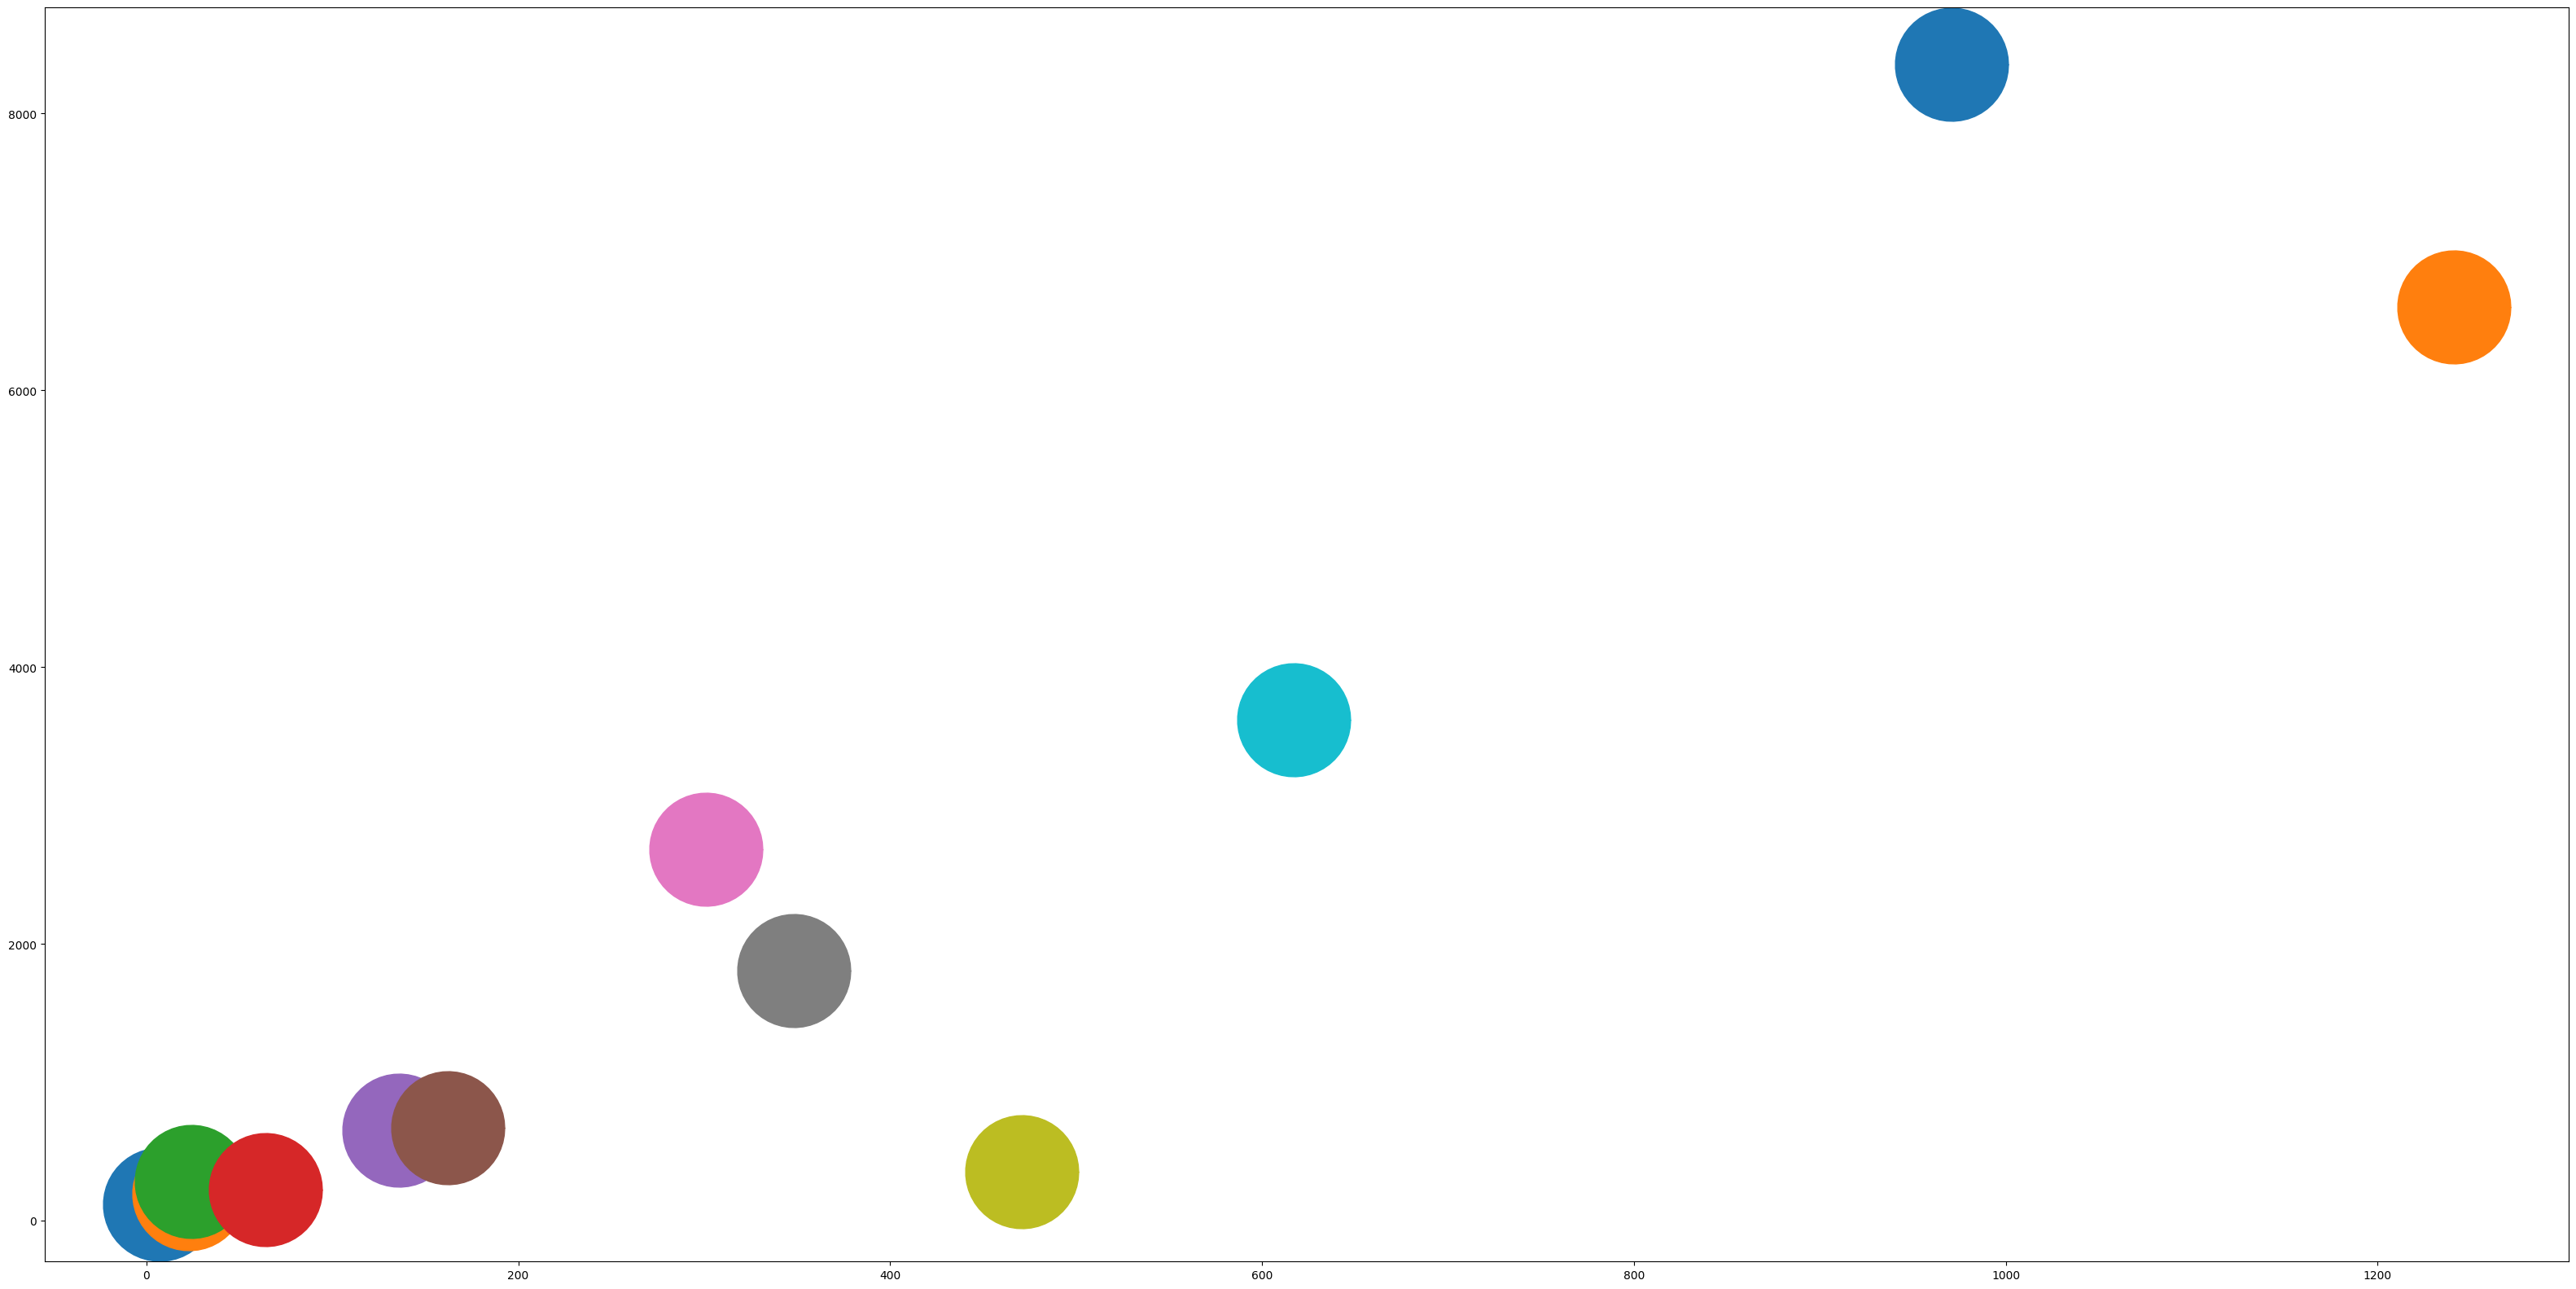

In [106]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(40,20))
for (x,y), d in not_supported_variant_impact_df.groupby(['Total Number Evidence Items','CIVIC Total Sum Impact Score']):
    dist = d['Category'].value_counts()
    draw_pie(dist, x, y, 10000*len(d), ax=ax)
plt.show()